In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
file = '../data/Hz31.txt'
data = pd.read_csv(file, names=['z', 'hz', 'err'], sep = " " )
data.describe()

,z,hz,err
count,31.000000,31.000000,31.000000
mean,0.661219,105.922581,21.303226
std,0.520398,38.413424,14.587768
min,0.070000,68.600000,4.000000
25%,0.275000,78.950000,12.000000
50%,0.470000,90.000000,17.000000
75%,0.890000,121.000000,27.900000
max,1.965000,202.000000,62.000000


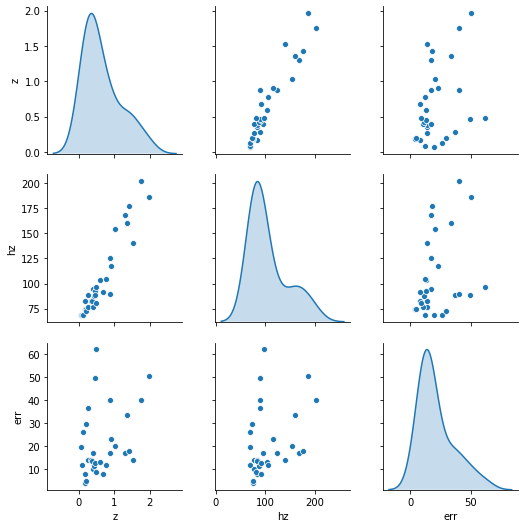

In [4]:
sns.pairplot(data, diag_kind="kde")
plt.savefig("DistHD.png")

In [5]:
# a = np.array([25,  3,  9,  7, 19,  2, 17, 16,  6, 28, 12, 20, 21, 26, 27, 11,  1,
#        10, 30, 13, 29,  0,  8, 18, 24,  5, 23,  4, 22, 15, 14])
# randomize = np.random.permutation(len(data.values))
shuffle = [x for x in range(len(data.values)) if x%2 ==0]
comp = [x for x in range(len(data.values)) if x%2 ==1]
shuffle.extend(comp)

data = data.values[shuffle]
# shuffle

In [6]:
# def norm(x):
#     return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_dataset)
# normed_test_data = norm(test_dataset)


Read the data for cosmic chronometers

In [7]:

# odds = [x for x in range(len(data)) if x%2 ==0]
# even = [x for x in range(len(data)) if x%2 ==1]
# new_order = np.array(even+odds)
# new_order = np.array([x for x in range(len(data)-1, 0, -1)])
# data = data.values[new_order]
# data = data.values


In [8]:
z = data[:,0]
y = data[:,1:]
# print(randomize)

In [9]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [10]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [11]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=50.0,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]
# initializer = Constant(value=0.01)
# initializer = RandomNormal()
#     efirst = Dense(150, activation='relu', input_shape=(1,))(input_z)
#     ehidden = Dense(50, activation='relu')(efirst)
# #     ehidden = Dense(150, activation='relu')(efirst)
#     ehidden2 = Dense(150, activation='relu')(ehidden)
#     ehidden2 = Dense(150, activation='relu')(ehidden2)
#     elast = Dense(2, activation='relu')(ehidden2)



In [12]:
def model(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(200, activation='relu')(efirst)
    ehidden2 = Dense(150, activation='relu')(ehidden)
    elast = Dense(2, activation='linear')(ehidden2)


    return elast


input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 50)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 200)               10200     
_________________________________________________________________
dense_2 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 302       
Total params: 40,752
Trainable params: 40,752
Non-trainable params: 0
_________________________________________________________________


In [13]:
# batch_size = 4
batch_size = 4
epochs = 100
input_z = Input(shape = (1,))

In [14]:
# autoencoder = Model(input_z, autoencoder(input_z))
# autoencoder.compile(loss='mean_squared_error', optimizer = "adam")
# autoencoder.summary()

In [15]:
model_train = neural_model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test))
#                                     callbacks=callbacks)

Epoch 1/100
6/6 [==============================] - 0s 18ms/step - loss: 5356.6929 - val_loss: 10970.5332
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 5318.4180 - val_loss: 10904.0850
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 5263.2202 - val_loss: 10812.1221
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 5178.5723 - val_loss: 10670.9980
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 5046.8999 - val_loss: 10465.8828
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 4838.0181 - val_loss: 10154.9775
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 4531.1440 - val_loss: 9643.2090
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 4059.2903 - val_loss: 8917.1816
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 3514.8445 - val_loss: 7929.7373
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - 

6/6 [==============================] - 0s 3ms/step - loss: 126.9688 - val_loss: 318.1285
Epoch 82/100
6/6 [==============================] - 0s 3ms/step - loss: 124.7159 - val_loss: 333.6743
Epoch 83/100
6/6 [==============================] - 0s 3ms/step - loss: 123.3328 - val_loss: 365.5928
Epoch 84/100
6/6 [==============================] - 0s 3ms/step - loss: 124.2338 - val_loss: 366.7116
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 123.4290 - val_loss: 351.5720
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 122.1975 - val_loss: 339.4148
Epoch 87/100
6/6 [==============================] - 0s 3ms/step - loss: 123.2495 - val_loss: 346.9756
Epoch 88/100
6/6 [==============================] - 0s 3ms/step - loss: 122.5356 - val_loss: 350.1384
Epoch 89/100
6/6 [==============================] - ETA: 0s - loss: 200.371 - 0s 3ms/step - loss: 121.8448 - val_loss: 351.9342
Epoch 90/100
6/6 [==============================] - 0s 3ms/step - los

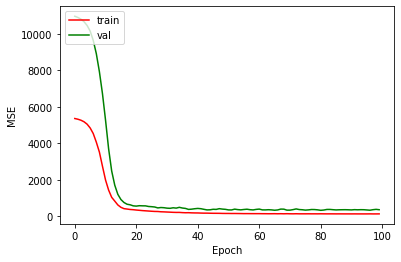

In [16]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_hz.png", dpi=200)


In [17]:
#uncer net
unet = np.sqrt(np.min(model_train.history['val_loss']))
print(np.min(model_train.history['loss']), np.min(model_train.history['val_loss']))
print(model_train.history['loss'][-1], model_train.history['val_loss'][-1])
# 119.81427764892578 311.0423889160156 120 epochs
# 120.7300033569336 355.0390930175781

120.40008544921875 318.12847900390625
122.64653778076172 351.1495056152344


In [18]:
pred = neural_model.predict(z_test)
pred

array([[ 89.86785 ,  18.270887],
       [101.23515 ,  20.50507 ],
       [112.50724 ,  22.731426],
       [114.076744,  23.042229],
       [141.56508 ,  28.485634],
       [150.71532 ,  30.301514],
       [173.46724 ,  34.822536]], dtype=float32)

In [19]:
#zor and yor are the original velues for z and [Hz, err]
zor = scalerz.inverse_transform(z.reshape(-1,1))
# yor = scalery.inverse_transform(y)

In [20]:
# ranz = np.random.uniform(0, 2, size=10000)
ranz = np.linspace(0, 2, 1000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = neural_model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
# predy = scalery.inverse_transform(pred_random)


(0.0, 2.0)

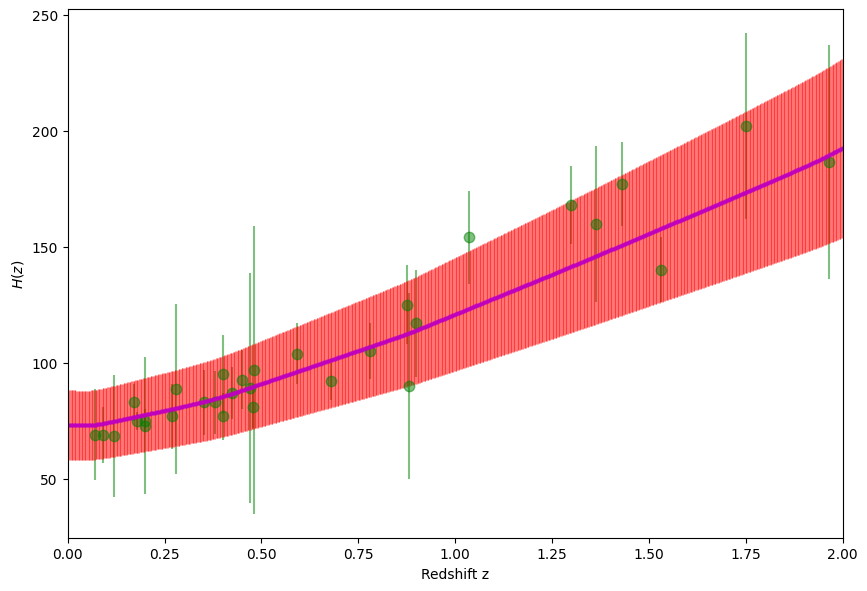

In [21]:
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.5, c='m')
plt.xlabel("Redshift z")

plt.ylabel("$H(z)$")
plt.xlim(0, 2)
# plt.savefig("500_epochs_HD.png")

In [22]:
# Cosmological constants
Om = 0.27
# variance network


In [23]:
def Hlcdm(z, H0=73.24):
    return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)

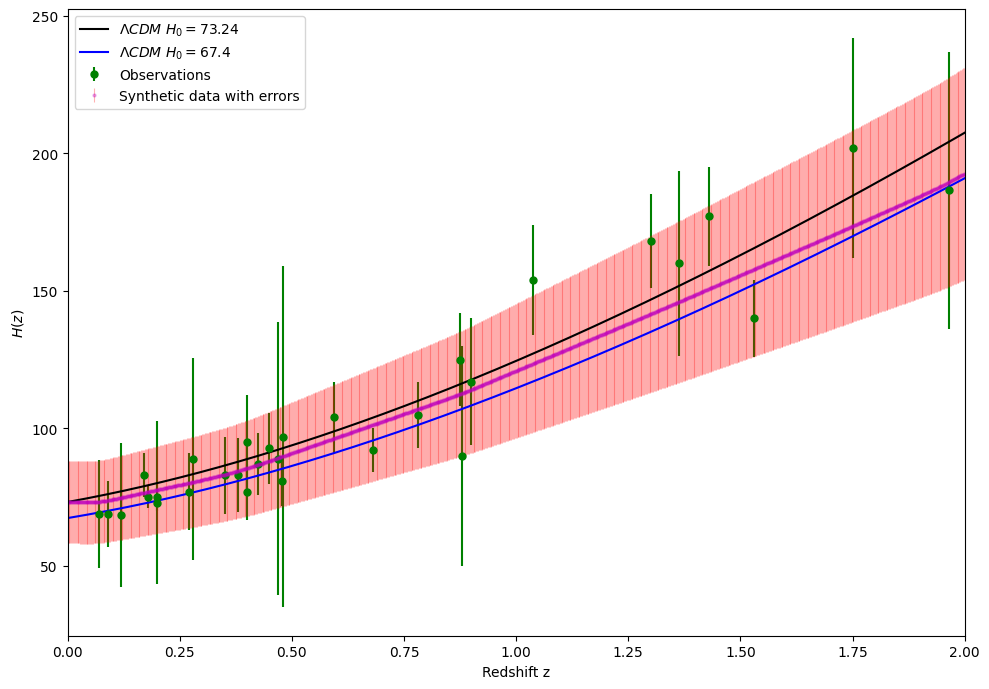

In [24]:
plt.figure(figsize=(10, 7), dpi=100)

zmodel = np.linspace(0, 2, 1000)
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=10, label='Observations')
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=4., label='Synthetic data with errors', alpha=0.01)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')

plt.errorbar(rr, pred_random[:,0], pred_random[:,1], markersize=2., fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with errors')

plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z")
plt.ylabel("$H(z)$")
plt.xlim(0, 2)
plt.tight_layout()
plt.legend(loc='upper left')

# plt.savefig("SyntheticHDrelu4.png",dpi=800)

In [25]:
pred_random.shape, r.shape

((1000, 2), (1000, 1))

In [26]:
# randomselection = np.random.randint(0,1000,50)
# randomselection = np.random.randint(0,1000,100)

# rr_reduced = rr[randomselection,:]
# predy_reduced = predy[randomselection,:]

# predy_reduced = pred_random[randomselection,:]
rr_reduced = rr
predy_reduced = pred_random

In [27]:
mookHz = np.concatenate((rr_reduced.reshape(-1,1), predy_reduced), axis=1)


# np.savetxt("autoEncoderHz50.dat",mookHz, delimiter=" ")

In [28]:
predy_reduced[:,1]

array([14.986617 , 14.983176 , 14.97974  , 14.976299 , 14.972862 ,
       14.969425 , 14.965989 , 14.962547 , 14.95911  , 14.955795 ,
       14.9540205, 14.9529085, 14.952191 , 14.951473 , 14.950753 ,
       14.950074 , 14.949396 , 14.948721 , 14.948041 , 14.947361 ,
       14.946683 , 14.946191 , 14.946962 , 14.947986 , 14.949418 ,
       14.950882 , 14.9523535, 14.954011 , 14.956569 , 14.959722 ,
       14.963608 , 14.969878 , 14.977817 , 14.986247 , 14.994681 ,
       15.003114 , 15.011548 , 15.01998  , 15.028411 , 15.036841 ,
       15.0453615, 15.055311 , 15.066434 , 15.0775585, 15.089297 ,
       15.102286 , 15.115268 , 15.128252 , 15.141238 , 15.154225 ,
       15.167212 , 15.180198 , 15.19318  , 15.206167 , 15.219152 ,
       15.232135 , 15.245173 , 15.25916  , 15.273146 , 15.287129 ,
       15.30112  , 15.315107 , 15.329093 , 15.34308  , 15.357064 ,
       15.371049 , 15.385037 , 15.399025 , 15.41301  , 15.426999 ,
       15.440984 , 15.45497  , 15.468955 , 15.482943 , 15.4969

In [29]:
error  = predy_reduced[:,1]**2
error

array([ 224.5987 ,  224.49557,  224.39261,  224.28954,  224.1866 ,
        224.0837 ,  223.98083,  223.87782,  223.77498,  223.67581,
        223.62273,  223.58948,  223.56802,  223.54655,  223.52502,
        223.50471,  223.48445,  223.46426,  223.44392,  223.4236 ,
        223.40334,  223.38863,  223.41168,  223.44228,  223.4851 ,
        223.52887,  223.57288,  223.62244,  223.69894,  223.79327,
        223.90956,  224.09726,  224.33499,  224.5876 ,  224.84047,
        225.09343,  225.34657,  225.59981,  225.85313,  226.1066 ,
        226.3629 ,  226.6624 ,  226.99744,  227.33276,  227.68689,
        228.07906,  228.47131,  228.86401,  229.2571 ,  229.65054,
        230.04431,  230.4384 ,  230.83272,  231.22752,  231.6226 ,
        232.01793,  232.41531,  232.84196,  233.26898,  233.69632,
        234.12427,  234.5525 ,  234.9811 ,  235.4101 ,  235.83942,
        236.26915,  236.69937,  237.12997,  237.56087,  237.9923 ,
        238.42398,  238.85611,  239.28857,  239.72151,  240.15

In [30]:
diagcov = np.diag(error) #inverso
# np.savetxt("autoEncoderHz_cov50.dat", diagcov, delimiter= " ", header="#50 50")
np.shape(diagcov)

(1000, 1000)

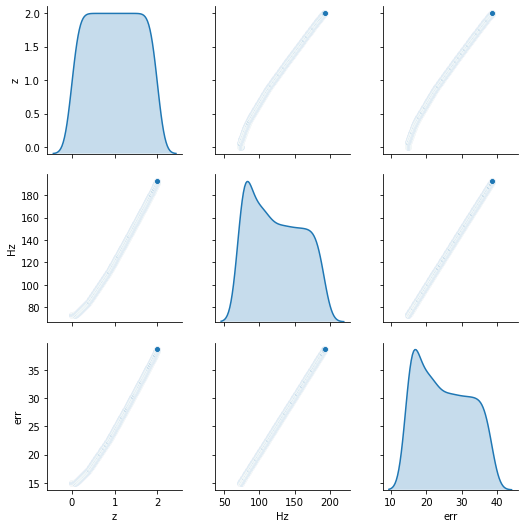

In [31]:
dfMook = pd.DataFrame(mookHz, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("50hdmook.png")

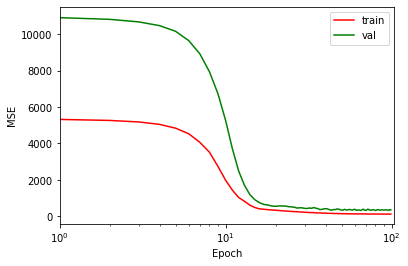

In [32]:
plt.plot(model_train.history['loss'], color='r')
plt.plot(model_train.history['val_loss'], color='g')
plt.xlim(1)
plt.xscale('log')
plt.ylabel('MSE')
# plt.yscale('log')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
# plt.savefig("loss_hz.png", dpi=200)
# plt.savefig("epochs_for_Hz.png", dpi=200)

In [33]:
def model2(input_z):
    x = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = Dense(200, activation='relu')(x)
    x = Dense(150, activation='relu')(x)
    x = Dense(2, activation='linear')(x)


    return elast


input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_5 (Dense)              (None, 200)               10200     
_________________________________________________________________
dense_6 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 302       
Total params: 40,752
Trainable params: 40,752
Non-trainable params: 0
_________________________________________________________________


#### Now, we not use the statistical error and only use a ANN to given redshift predict $H(z)$. And we estimates its uncertainty with dropout layers.

In [34]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((24, 1), (24, 1), (7, 1), (7, 1))

In [35]:
from astroNN.nn.layers import MCDropout

In [36]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[50, 200, 150])
model.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model2_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=800,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/800
6/6 [==============================] - 0s 19ms/step - loss: 5378.6367 - val_loss: 11037.3105
Epoch 2/800
6/6 [==============================] - 0s 3ms/step - loss: 5377.4858 - val_loss: 11041.1416
Epoch 3/800
6/6 [==============================] - 0s 3ms/step - loss: 5373.3550 - val_loss: 11009.3691
Epoch 4/800
6/6 [==============================] - 0s 4ms/step - loss: 5367.2017 - val_loss: 11028.1641
Epoch 5/800
6/6 [==============================] - 0s 4ms/step - loss: 5368.6958 - val_loss: 11022.7939
Epoch 6/800
6/6 [==============================] - 0s 3ms/step - loss: 5370.5298 - val_loss: 11027.1777
Epoch 7/800
6/6 [==============================] - 0s 3ms/step - loss: 5366.0103 - val_loss: 11006.9316
Epoch 8/800
6/6 [==============================] - 0s 4ms/step - loss: 5361.4253 - val_loss: 11000.5078
Epoch 9/800
6/6 [==============================] - 0s 3ms/step - loss: 5358.7173 - val_loss: 11000.7744
Epoch 10/800
6/6 [==============================] - 0s 4ms/step

6/6 [==============================] - 0s 3ms/step - loss: 3044.1387 - val_loss: 7456.6499
Epoch 80/800
6/6 [==============================] - 0s 3ms/step - loss: 3088.9578 - val_loss: 7579.5688
Epoch 81/800
6/6 [==============================] - 0s 3ms/step - loss: 2741.6858 - val_loss: 7350.7065
Epoch 82/800
6/6 [==============================] - 0s 3ms/step - loss: 2747.0596 - val_loss: 6953.4956
Epoch 83/800
6/6 [==============================] - 0s 3ms/step - loss: 2717.8337 - val_loss: 7114.8506
Epoch 84/800
6/6 [==============================] - 0s 3ms/step - loss: 2551.9597 - val_loss: 6751.4663
Epoch 85/800
6/6 [==============================] - 0s 3ms/step - loss: 2664.6172 - val_loss: 6402.8091
Epoch 86/800
6/6 [==============================] - 0s 3ms/step - loss: 2344.7217 - val_loss: 6314.3906
Epoch 87/800
6/6 [==============================] - 0s 3ms/step - loss: 2310.9683 - val_loss: 5962.7466
Epoch 88/800
6/6 [==============================] - 0s 3ms/step - loss: 2269.

Epoch 158/800
6/6 [==============================] - 0s 3ms/step - loss: 377.5456 - val_loss: 1348.1448
Epoch 159/800
6/6 [==============================] - 0s 3ms/step - loss: 366.3266 - val_loss: 969.4307
Epoch 160/800
6/6 [==============================] - 0s 3ms/step - loss: 443.0731 - val_loss: 588.1136
Epoch 161/800
6/6 [==============================] - 0s 3ms/step - loss: 332.6012 - val_loss: 917.7013
Epoch 162/800
6/6 [==============================] - 0s 3ms/step - loss: 504.1909 - val_loss: 752.0563
Epoch 163/800
6/6 [==============================] - 0s 3ms/step - loss: 315.0335 - val_loss: 1068.5986
Epoch 164/800
6/6 [==============================] - 0s 3ms/step - loss: 378.8274 - val_loss: 873.8764
Epoch 165/800
6/6 [==============================] - 0s 3ms/step - loss: 426.8766 - val_loss: 861.1079
Epoch 166/800
6/6 [==============================] - 0s 3ms/step - loss: 504.0885 - val_loss: 663.9517
Epoch 167/800
6/6 [==============================] - 0s 3ms/step - loss

6/6 [==============================] - 0s 3ms/step - loss: 302.5295 - val_loss: 944.9567
Epoch 238/800
6/6 [==============================] - 0s 3ms/step - loss: 285.5529 - val_loss: 591.9205
Epoch 239/800
6/6 [==============================] - 0s 3ms/step - loss: 292.5393 - val_loss: 676.1271
Epoch 240/800
6/6 [==============================] - 0s 2ms/step - loss: 328.1351 - val_loss: 736.6113
Epoch 241/800
6/6 [==============================] - 0s 3ms/step - loss: 367.8111 - val_loss: 633.8724
Epoch 242/800
6/6 [==============================] - 0s 3ms/step - loss: 428.6626 - val_loss: 746.4870
Epoch 243/800
6/6 [==============================] - 0s 3ms/step - loss: 257.7129 - val_loss: 641.2916
Epoch 244/800
6/6 [==============================] - 0s 3ms/step - loss: 410.3275 - val_loss: 512.8610
Epoch 245/800
6/6 [==============================] - 0s 3ms/step - loss: 567.8538 - val_loss: 654.0156
Epoch 246/800
6/6 [==============================] - 0s 3ms/step - loss: 348.3844 - val

6/6 [==============================] - 0s 3ms/step - loss: 316.8990 - val_loss: 1131.7650
Epoch 317/800
6/6 [==============================] - 0s 3ms/step - loss: 291.0437 - val_loss: 1000.8361
Epoch 318/800
6/6 [==============================] - 0s 3ms/step - loss: 319.3065 - val_loss: 439.5677
Epoch 319/800
6/6 [==============================] - 0s 3ms/step - loss: 357.7562 - val_loss: 551.5965
Epoch 320/800
6/6 [==============================] - 0s 3ms/step - loss: 327.7619 - val_loss: 716.9017
Epoch 321/800
6/6 [==============================] - 0s 3ms/step - loss: 198.7534 - val_loss: 761.4681
Epoch 322/800
6/6 [==============================] - 0s 3ms/step - loss: 374.1467 - val_loss: 550.1077
Epoch 323/800
6/6 [==============================] - 0s 3ms/step - loss: 509.3414 - val_loss: 760.6136
Epoch 324/800
6/6 [==============================] - 0s 3ms/step - loss: 299.5285 - val_loss: 571.4101
Epoch 325/800
6/6 [==============================] - 0s 3ms/step - loss: 348.4671 - v

6/6 [==============================] - 0s 3ms/step - loss: 385.3728 - val_loss: 595.1777
Epoch 396/800
6/6 [==============================] - 0s 3ms/step - loss: 227.3468 - val_loss: 437.9850
Epoch 397/800
6/6 [==============================] - 0s 3ms/step - loss: 360.6752 - val_loss: 546.4882
Epoch 398/800
6/6 [==============================] - 0s 3ms/step - loss: 176.3772 - val_loss: 501.2234
Epoch 399/800
6/6 [==============================] - 0s 3ms/step - loss: 330.5237 - val_loss: 402.9790
Epoch 400/800
6/6 [==============================] - 0s 3ms/step - loss: 219.6986 - val_loss: 481.5703
Epoch 401/800
6/6 [==============================] - 0s 3ms/step - loss: 285.1003 - val_loss: 649.9805
Epoch 402/800
6/6 [==============================] - 0s 3ms/step - loss: 214.8776 - val_loss: 525.3166
Epoch 403/800
6/6 [==============================] - 0s 3ms/step - loss: 299.1645 - val_loss: 502.6580
Epoch 404/800
6/6 [==============================] - 0s 3ms/step - loss: 212.1430 - val

6/6 [==============================] - 0s 3ms/step - loss: 211.2661 - val_loss: 575.5090
Epoch 475/800
6/6 [==============================] - 0s 3ms/step - loss: 190.7608 - val_loss: 863.0618
Epoch 476/800
6/6 [==============================] - 0s 3ms/step - loss: 294.3319 - val_loss: 695.4665
Epoch 477/800
6/6 [==============================] - 0s 3ms/step - loss: 212.5086 - val_loss: 796.3506
Epoch 478/800
6/6 [==============================] - 0s 3ms/step - loss: 173.6801 - val_loss: 511.7390
Epoch 479/800
6/6 [==============================] - 0s 3ms/step - loss: 236.4876 - val_loss: 307.6793
Epoch 480/800
6/6 [==============================] - 0s 3ms/step - loss: 283.6522 - val_loss: 644.3473
Epoch 481/800
6/6 [==============================] - 0s 3ms/step - loss: 239.6425 - val_loss: 455.1861
Epoch 482/800
6/6 [==============================] - 0s 3ms/step - loss: 221.9272 - val_loss: 627.4081
Epoch 483/800
6/6 [==============================] - 0s 3ms/step - loss: 225.4808 - val

6/6 [==============================] - 0s 3ms/step - loss: 260.4625 - val_loss: 555.9761
Epoch 554/800
6/6 [==============================] - 0s 3ms/step - loss: 207.9535 - val_loss: 511.2376
Epoch 555/800
6/6 [==============================] - 0s 3ms/step - loss: 253.9885 - val_loss: 750.1611
Epoch 556/800
6/6 [==============================] - 0s 3ms/step - loss: 278.6950 - val_loss: 580.9716
Epoch 557/800
6/6 [==============================] - 0s 3ms/step - loss: 313.4062 - val_loss: 420.3339
Epoch 558/800
6/6 [==============================] - 0s 3ms/step - loss: 159.3291 - val_loss: 322.9680
Epoch 559/800
6/6 [==============================] - 0s 3ms/step - loss: 348.6816 - val_loss: 519.1581
Epoch 560/800
6/6 [==============================] - 0s 3ms/step - loss: 219.1879 - val_loss: 674.1906
Epoch 561/800
6/6 [==============================] - 0s 3ms/step - loss: 218.1151 - val_loss: 370.4995
Epoch 562/800
6/6 [==============================] - 0s 3ms/step - loss: 284.0669 - val

6/6 [==============================] - 0s 3ms/step - loss: 229.9945 - val_loss: 551.8771
Epoch 633/800
6/6 [==============================] - 0s 3ms/step - loss: 270.3709 - val_loss: 342.0599
Epoch 634/800
6/6 [==============================] - 0s 3ms/step - loss: 272.2591 - val_loss: 416.8917
Epoch 635/800
6/6 [==============================] - 0s 3ms/step - loss: 161.0885 - val_loss: 561.0580
Epoch 636/800
6/6 [==============================] - 0s 3ms/step - loss: 216.3861 - val_loss: 1116.1243
Epoch 637/800
6/6 [==============================] - 0s 3ms/step - loss: 182.2184 - val_loss: 499.7258
Epoch 638/800
6/6 [==============================] - 0s 3ms/step - loss: 238.3855 - val_loss: 461.9482
Epoch 639/800
6/6 [==============================] - 0s 3ms/step - loss: 177.7996 - val_loss: 557.9257
Epoch 640/800
6/6 [==============================] - 0s 3ms/step - loss: 176.5842 - val_loss: 428.7732
Epoch 641/800
6/6 [==============================] - 0s 3ms/step - loss: 207.8752 - va

6/6 [==============================] - 0s 3ms/step - loss: 216.6279 - val_loss: 500.2305
Epoch 712/800
6/6 [==============================] - 0s 3ms/step - loss: 183.8139 - val_loss: 547.0637
Epoch 713/800
6/6 [==============================] - 0s 3ms/step - loss: 195.1786 - val_loss: 359.7117
Epoch 714/800
6/6 [==============================] - 0s 3ms/step - loss: 309.9485 - val_loss: 503.1563
Epoch 715/800
6/6 [==============================] - 0s 3ms/step - loss: 203.3696 - val_loss: 737.3608
Epoch 716/800
6/6 [==============================] - 0s 3ms/step - loss: 309.5094 - val_loss: 507.9941
Epoch 717/800
6/6 [==============================] - 0s 3ms/step - loss: 158.4087 - val_loss: 883.9688
Epoch 718/800
6/6 [==============================] - 0s 3ms/step - loss: 181.8156 - val_loss: 388.7411
Epoch 719/800
6/6 [==============================] - 0s 3ms/step - loss: 154.2506 - val_loss: 692.4218
Epoch 720/800
6/6 [==============================] - 0s 3ms/step - loss: 280.1886 - val

6/6 [==============================] - 0s 3ms/step - loss: 166.4541 - val_loss: 792.1241
Epoch 791/800
6/6 [==============================] - 0s 3ms/step - loss: 240.6163 - val_loss: 543.2888
Epoch 792/800
6/6 [==============================] - 0s 3ms/step - loss: 206.8598 - val_loss: 330.2088
Epoch 793/800
6/6 [==============================] - 0s 3ms/step - loss: 206.9627 - val_loss: 912.2591
Epoch 794/800
6/6 [==============================] - 0s 3ms/step - loss: 173.3821 - val_loss: 619.9418
Epoch 795/800
6/6 [==============================] - 0s 3ms/step - loss: 223.8227 - val_loss: 654.7609
Epoch 796/800
6/6 [==============================] - 0s 3ms/step - loss: 221.1418 - val_loss: 553.9433
Epoch 797/800
6/6 [==============================] - 0s 3ms/step - loss: 208.2072 - val_loss: 407.5110
Epoch 798/800
6/6 [==============================] - 0s 3ms/step - loss: 254.3233 - val_loss: 407.3910
Epoch 799/800
6/6 [==============================] - 0s 4ms/step - loss: 185.6057 - val

In [37]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 2., test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

In [38]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

(15.596888780180423, 5.24738817272533)

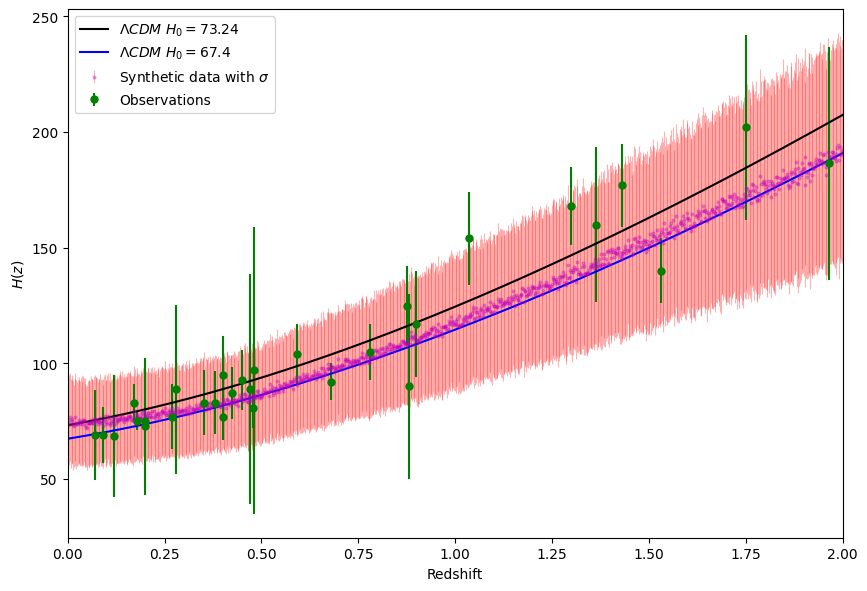

In [39]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(0,2)
plt.xlabel('Redshift')
plt.ylabel('$H(z)$')
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.savefig('Hz_dropout800.png', dpi=100)

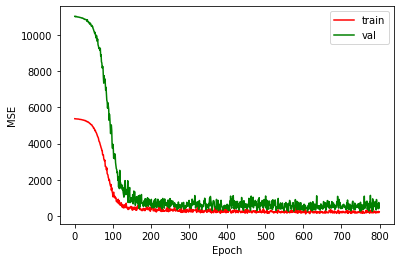

In [40]:
plt.plot(model2_train.history['loss'], color='r')
plt.plot(model2_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig('lossHzdropout10mil.png', dpi=100)

In [41]:
mookdpHz = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)

# np.savetxt("autoEncoderHz50dropout.dat",mookdpHz, delimiter=" ")

In [42]:
diagcov2 = np.diag(sigma**2) #inverso
# np.savetxt("autoEncoderHz_cov50dropout.dat", diagcov2, delimiter= " ", header="#50 50")

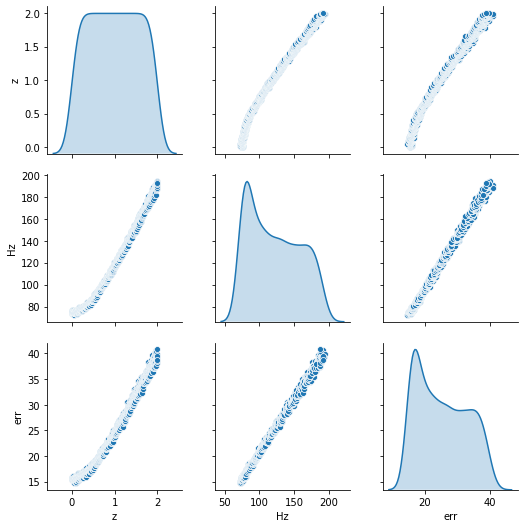

In [43]:
dfMook = pd.DataFrame(mookdpHz, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("50hdmookdropout.png")